# Eve Online Market Price Predictions: Acolyte I

## Getting item history

In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import pandas as pd
import requests

In [2]:
ESI_ENDPOINT = "https://esi.evetech.net/latest"
SERVER_NAME = "tranquility"
REGION = "The Forge"
ITEM = "Acolyte I"

def search_id(name, categories, strict=False):
    search_path = f"{ESI_ENDPOINT}/search/"
    headers = {
        "categories": categories,
        "datasource": SERVER_NAME,
        "search": name,
        "strict": strict
    }
    res = requests.get(search_path, headers)
    res.raise_for_status()
    return res.json()

region = search_id(REGION, ["region"])["region"][0]
item = search_id(ITEM, ["inventory_type"], True)["inventory_type"][0]

def get_market_history(region_id, type_id):
    history_path = f"{ESI_ENDPOINT}/markets/{str(region_id)}/history"
    headers = {
        "region_id": region_id,
        "type_id": type_id
    }
    res = requests.get(history_path, headers)
    res.raise_for_status()
    return res.json()

history_json = get_market_history(region, item)
history = pd.DataFrame.from_records(history_json)

history.describe()

,average,highest,lowest,order_count,volume
count,399.000000,399.000000,399.000000,399.000000,399.000000
mean,2952.119474,3242.308195,2729.661178,314.664160,8711.280702
std,997.352386,1564.443573,909.537231,57.881507,10188.492251
min,613.110000,1100.010000,612.000000,213.000000,1433.000000
25%,2219.720000,2384.975000,2100.000000,272.500000,4159.000000
50%,2805.000000,2989.990000,2600.100000,307.000000,6163.000000
75%,3503.105000,3834.010000,3003.670000,350.000000,9615.500000
max,8000.000000,24349.940000,8000.000000,559.000000,136819.000000


In [3]:
history_dates = history["date"]
history_averages = history["average"]
df = pd.DataFrame({"date": history_dates, "average": history_averages})
df.date = pd.to_datetime(df.date) # Convert date string to datetime type.

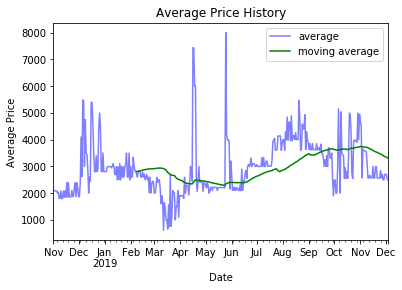

In [4]:
ax = df.plot(x="date", y="average", color="blue", alpha=0.5)
mavg = pd.DataFrame({"date": df.date, "moving average": df.average.rolling(window=100).mean()})
mavg.plot(x="date", y="moving average", color="green", ax=ax)
ax.set_title("Average Price History")
ax.set_xlabel("Date")
ax.set_ylabel("Average Price")
plt.show()

In [5]:
removed_outliers = df.average.between(df.average.quantile(0.05), df.average.quantile(0.95))
index_names = df[~removed_outliers].index
df.drop(index_names, inplace=True)

In [6]:
def prepare_input_data(data):
    return data.astype(float).reshape(-1, 1)

def draw_prediction_plot(true_x, true_y, pred_x, pred_y, title, x_label, y_label):
    plt.scatter(x=true_x, y=true_y, color="blue")
    plt.scatter(x=pred_x, y=pred_y, color="red")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(["Expected", "Predicted"], loc="upper right")
    plt.show()

In [7]:
test_size = 0.4
train, test = train_test_split(df, test_size=test_size)

X_train = prepare_input_data(train.date.values)
y_train = prepare_input_data(train.average.values)

X_test = prepare_input_data(test.date.values)
y_test = prepare_input_data(test.average.values)

## Polynomial Regression

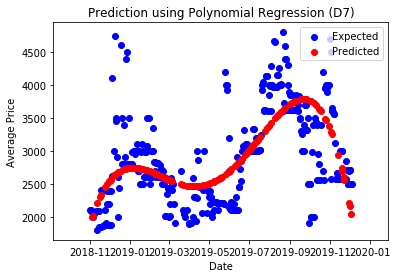

In [8]:
degree = 7
poly = make_pipeline(PolynomialFeatures(degree=degree), Ridge())
poly.fit(X_train, y_train)

poly_pred = poly.predict(X_test)

draw_prediction_plot(df.date.values, df.average.values, test.date.values, 
                     poly_pred, f"Prediction using Polynomial Regression (D{degree})",
                     "Date", "Average Price")

In [9]:
confidence = poly.score(X_test, y_test)
print("Polynomial regression confidence: ", confidence)

knn_mse = mean_squared_error(y_test, poly_pred)
knn_rmse = np.sqrt(knn_mse)
print("Polynomial regression typical error: ", knn_rmse)

Polynomial regression confidence:  0.3564189904476176
Polynomial regression typical error:  567.7096996242698


## k-Nearest Neighbors

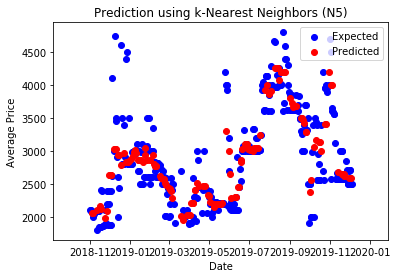

In [10]:
neighbors = 5
knn = KNeighborsRegressor(n_neighbors=neighbors)
knn.fit(X_train, y_train)

knn_pred = knn.predict(X_test)

draw_prediction_plot(df.date.values, df.average.values, test.date.values, 
                     knn_pred, f"Prediction using k-Nearest Neighbors (N{neighbors})",
                     "Date", "Average Price")

In [11]:
confidence = knn.score(X_test, y_test)
print("k-Nearest Neighbors confidence: ", confidence)

knn_mse = mean_squared_error(y_test, knn_pred)
knn_rmse = np.sqrt(knn_mse)
print("k-Nearest Neighbors typical error: ", knn_rmse)
      

k-Nearest Neighbors confidence:  0.6456139904255902
k-Nearest Neighbors typical error:  421.27238200341753


## Decision Tree

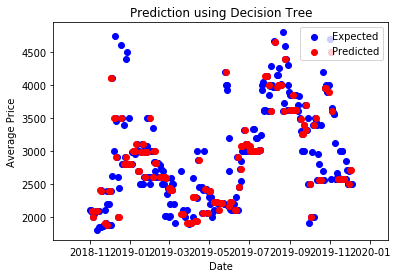

In [12]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

tree_pred = tree_reg.predict(X_test)

draw_prediction_plot(df.date.values, df.average.values, test.date.values, 
                     tree_pred, "Prediction using Decision Tree",
                     "Date", "Average Price")

In [13]:
confidence = tree_reg.score(X_test, y_test)
print("Decision tree confidence: ", confidence)

tree_mse = mean_squared_error(y_test, tree_pred)
tree_rmse = np.sqrt(tree_mse)
print("Decision tree typical error: ", tree_rmse)


Decision tree confidence:  0.5074849206191165
Decision tree typical error:  496.6317376427203
